# Natural Language Processing of the Yelp Review Challenge Data set
## Our repo: https://github.com/lonnagee/4447-Project

## Introduction:
In the era of digital transformation, online reviews have become a powerful driving force influencing consumer choices and business reputation. Yelp, a prominent user-generated review platform, houses a vast repository of valuable insights encapsulated within millions of reviews. This project delves into the Yelp review dataset, employing data cleaning and natural language processing techniques to uncover hidden patterns and sentiments. By analyzing this rich textual data, we aim to assist businesses in understanding customer feedback, enhancing their services, and gaining an edge in an ever-competitive market. Let us embark on a journey of data exploration and sentiment analysis, revealing the untold story behind Yelp's myriad reviews.

## Motivation and Dataset Description:
Yelp is a popular online platform where users can provide reviews and ratings for businesses ranging from restaurants, cafes, and bars to local services and shops. The Yelp review dataset offers a wealth of information from millions of user-generated reviews, making it a valuable resource for conducting data-driven analyses and gaining insights into customer sentiments and behavior.

The primary motivation behind this project is to explore the Yelp review dataset and leverage natural language processing (NLP) techniques to uncover patterns, sentiments, and trends hidden within the vast volume of textual data. By harnessing NLP, we aim to extract valuable information from the reviews, such as sentiment polarity, key phrases, and common topics, that can aid businesses in understanding customer feedback and enhancing their services.

## Dataset Description:
The Yelp review dataset is a comprehensive collection of user reviews, encompassing multiple attributes such as user IDs, business IDs, review text, and star ratings. The dataset spans diverse geographical locations, businesses, and user demographics, providing a rich and varied set of reviews.

The main columns in the dataset include:

- `review_id`: A unique identifier for each review.
- `user_id`: The identifier of the user who wrote the review.
- `business_id`: The identifier of the business being reviewed.
- `stars`: The star rating given by the user (ranging from 1 to 5).
- `useful`, `funny`, `cool`: The counts of how many users marked the review as useful, funny, or cool.
- `text`: The textual content of the review.
- `date`: The date and time when the review was posted.

The dataset contains millions of reviews, making it a massive corpus of text that can be mined for valuable insights. However, like any real-world dataset, it also presents challenges, such as missing data, potential outliers, and the need for proper data cleaning and preprocessing.

By analyzing the Yelp review dataset, we aim to unravel patterns of user behavior, perform sentiment analysis to gauge customer sentiments, and contribute to a better understanding of user feedback on various businesses.

## Research Question
How well can sentiment analysis accurately predict the sentiment polarity of Yelp reviews compared to the user-provided star ratings?

In this study, we aim to employ Natural Language Processing (NLP) techniques, such as the VADER SentimentIntensityAnalyzer, to extract sentiment scores from the textual content of Yelp reviews. The research question focuses on comparing these sentiment scores with the star ratings assigned by users to assess the level of alignment between sentiment and rating.

Through this analysis, we seek to explore whether the extracted sentiments closely align with the star ratings or if there are instances of discrepancies. By validating the sentiment analysis against user ratings, we aim to gain insights into the efficacy of NLP methods for capturing sentiment from reviews and uncover any underlying patterns in the user feedback.

## Required Libraries

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import regex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import concurrent.futures as ccf
from sklearn.metrics import f1_score

## Get Data

Our first step is to pull in the data.  The dataset is a available from Yelp as a tar file, or tape archive file: https://www.yelp.com/dataset.  By using a Tar file, Yelp was able to compress the data into a more manageable file.  This required separate extraction of the individual files from the dataset (each of our teammates did this individually outside of their Jupyter notebook). 

The particular files available from the Tar file downloaded are all for academic use only, and included more than just the review dataset of interest to us.  There are also datasets for businesses, checkin, tips, and users.

Once extracted from the Tar file, the file was immediately available as a JSON file, or a script we created could be used to convert it to CSV.


The main challenege we experienced in working with the review data set was the size of it.  It is approximately 6 million rows so loading, cleaning, and creating a model were problematic.  We also explored working with PySpark because it could allow us to better handle the size of our dataset, however the syntax of PySpark created an additional challenge that in the end, we felt was not worth.  Using a Pandas DataFrame allowed us to clearly see the data and manipulate it as necessary.

In order to be able to process this throughout our work we chose to use 1 million rows.

In [2]:
# We used python to extract the data from the tar file and save it to a csv file in the /data folder
try:
    reviews_df_raw = pd.read_csv('yelp_academic_dataset_review.csv')
    if reviews_df is not None:
        reviews_df = reviews_df_raw
except Exception as ex:
    print(ex, "\nTrying json")
    
try:
    reviews_df = pd.read_json('yelp_academic_dataset_review.json',lines=True, nrows =1000000)
except Exception as ex:
    print(ex)

[Errno 2] No such file or directory: 'yelp_academic_dataset_review.csv' 
Trying json


## Initial Exploratory Data Analysis

#### Let's look at the head of the DataFrame to get an idea of the structure of the data

In [3]:
reviews_df.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30


#### By using the info method we can examine the number of rows and how many non-null entries we have in each column

In [4]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   review_id    1000000 non-null  object        
 1   user_id      1000000 non-null  object        
 2   business_id  1000000 non-null  object        
 3   stars        1000000 non-null  int64         
 4   useful       1000000 non-null  int64         
 5   funny        1000000 non-null  int64         
 6   cool         1000000 non-null  int64         
 7   text         1000000 non-null  object        
 8   date         1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 68.7+ MB


#### Checking for null values in our columns

In [5]:
reviews_df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

#### It appears we do not have any null values that require cleaning, which is great news!

#### Checking for Duplicate reviews

Our next challenge was removing duplicate data.  Duplicated reviews would skew our NLP analysis, adding additional weight to a given star rating.

In [6]:
duplicate_rows = reviews_df.duplicated().sum()
duplicate_review_text = reviews_df.duplicated(subset=['text']).sum()

print(f'Count of duplicate rows: {duplicate_rows}')
print(f'Count of duplicate review text: {duplicate_review_text}')

Count of duplicate rows: 0
Count of duplicate review text: 1643


In [7]:
duplicate_review_text_df = reviews_df[reviews_df.duplicated(subset='text', keep=False)]
sorted_duplicate_review_text_df = duplicate_review_text_df.sort_values(by='text')
sorted_duplicate_review_text_df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
586767,Oz8E7WQ5JVlrCC6-PGdY8Q,Xf5hPJl9P4r9rRAy-NR46g,UCMSWPqzXjd7QHq7v8PJjQ,5,1,0,1,"""Prep's Breakfast Sammie"" is the BEST breakfas...",2020-09-10 20:10:14
498137,uZ0nZRQ-RpttoLCym2DyHw,Xf5hPJl9P4r9rRAy-NR46g,UCMSWPqzXjd7QHq7v8PJjQ,5,0,0,0,"""Prep's Breakfast Sammie"" is the BEST breakfas...",2019-05-06 01:51:19
245489,ZEJh91IrecK11ggjvgohnA,4A1DHbi0g7agi53yzGUoYw,BxveuvYElRjEIuVNiJAEtA,4,0,0,1,"""The Best In The West Nugget Rib Cook-Off"" I l...",2015-09-07 22:47:18
170462,Nsz_GV1LHlnvrTwVWd0jdw,4A1DHbi0g7agi53yzGUoYw,BxveuvYElRjEIuVNiJAEtA,4,0,0,0,"""The Best In The West Nugget Rib Cook-Off"" I l...",2015-09-05 17:36:42
416542,CF4rf7--EneYMVHAPgX7Jg,oUzXQqxXkFGL5k1OEmFr4g,34Eqv8jXgxg_EEwcsNgeeg,2,0,0,0,"""We ran out of bread"" they said, as we drove o...",2020-02-23 05:47:39
...,...,...,...,...,...,...,...,...,...
477265,ylizkgF4T1lzOhePMcuYXA,q6oeAeoexeCeKguomN_YHw,L3h60m908xbwVGI0_O4Ikw,1,0,0,0,the lunch meat I just got was sour. tasted ter...,2013-04-24 14:36:19
617079,gSlvqsu8lYJYQ0skJskYiw,ftAlCeyaXHXSAVFxbwMvAA,yE1raqkLX7OZsjmX3qKIKg,5,1,0,0,us had a GNO and decided on short notice to tr...,2017-07-31 16:35:02
655993,Em5l1TCmLacdkeGaW6CdCg,ftAlCeyaXHXSAVFxbwMvAA,yE1raqkLX7OZsjmX3qKIKg,5,1,0,1,us had a GNO and decided on short notice to tr...,2016-12-24 18:40:12
161306,LI4sOmBZkPbIpR29DmBJ5A,ZmLio_71X_ryHKsEg4YmiA,F6lNQPwg4gyg76wNyimxjQ,5,0,0,0,what a great time my whole family had.our driv...,2016-09-25 22:37:07


#### Dropping any duplicate reviews

In [8]:
reviews_df = reviews_df[~reviews_df.duplicated(["text"])]
len(reviews_df)

998357

## Data Visualization
Our next phase of data exploration is to visualize the data and try to better understand its content and distribution.


#### Countplot
We started with a Seaborn countplot of the stars rating in order to better understand the distribution.  We can see that our data is skewed towards five star reviews, as well as four star reviews.  This may present a challenge later as we look at data for one to three star reviews and attempt to use NLP to predict star ratings.

Text(0, 0.5, 'Count')

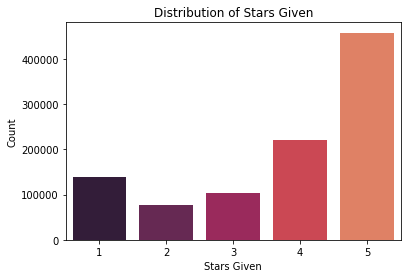

In [9]:
sns.set_palette('rocket')
sns.countplot(x = 'stars', data = reviews_df)
plt.title("Distribution of Stars Given")
plt.xlabel("Stars Given")
plt.ylabel("Count")

### Creating Wordclouds
Since we are concerned with NLP and textual data, we next decided to look at wordclouds for reviews for all stars (the entire dataset), and then 1, 3, and 5 star reviews.  A WordCloud is a visual representation of the data and will display more common words in larger and bolder font to place emphasis on their frequency within a corpus.

Wordclouds can help us visualize common themes, however unlike NLP, they cannot take into account synonyms and context, falling short of providing insight into sentiment, but still providing insight into commonly used words among textual data.  The algorithm for the Wordcloud library is the most simple available and therefore also easy to use and generate, however it does use a "stupid simple algorithm" according to the developer, which they also acknowledge is inefficient.  There are more complex and customizable wordcloud libraries available, for example PyWordCloud.  Given the plans we have for our data, we chose to proceed with the Wordcloud library.

To set up a wordcloud for each of our data subsets:
* We first set stopwords, which are words not to be included in our word cloud
* Next, we joined each word into a single long string from the 'text' portion of users' reviews
* Then we generate the wordcloud (indicating the stopwords so they are not included in the algorithm that creates the image)




#### This first wordcloud is for all values of stars given

We are not surprised to see words like "great", "good", "time", "back", "food", "service", "friendly", and finally, "place" pop out given the reviews we have seen online and would expect to see.

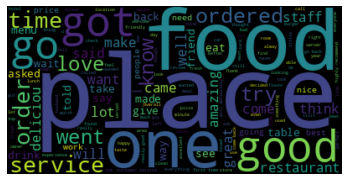

<Figure size 2160x1440 with 0 Axes>

In [10]:
stopwords = set(STOPWORDS)

all_words = " ".join(review for review in reviews_df['text'])
all_wc = WordCloud(stopwords = stopwords).generate(all_words)

plt.imshow(all_wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize = (30,20))
plt.show()

#### How does a wordcloud for only 5 star reviews look?

"Delicious", "good", "great", "food", "best", and "place" all really stand out in this review, which also brings us back to the countplot we saw above. We know the data is skewed towards five star revies, so are not surprised to see many of the same words stand out in this wordcloud versus looking at the wordcloud for all reviews above.

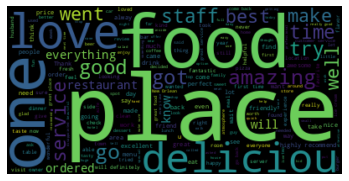

In [11]:
five_df = reviews_df[reviews_df['stars'] == 5]
five_df.head()
five_words = " ".join(review for review in five_df['text'])
five_wc = WordCloud(stopwords = stopwords).generate(five_words)
plt.imshow(five_wc, interpolation='bilinear')
plt.axis("off")

plt.show()

#### Next, we looked at a wordcloud for 3 star reviews

An mid-range rating from a reviewer included "good", "great", "food, "service", "nice", "place", "price".  We see many of the same words that we saw above in the five star reviews.  Hopefully this does not muddy the waters too much as we get into our NLP predictions later.

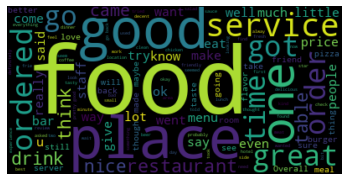

In [12]:
three_df = reviews_df[reviews_df['stars'] == 3]

three_words = " ".join(review for review in three_df['text'])
three_wc = WordCloud(stopwords = stopwords).generate(three_words)
plt.imshow(three_wc, interpolation='bilinear')
plt.axis("off")

plt.show()

#### Last, we can compare those to one star reviews

On Yelp, you have to give at least one star.  There is no zero of half-star options.  So the worst rating a reviewee could provide also prominently included many of the same reviews we saw for three and five star reviews.

Overall, althought the wordclouds are helpful for visualizing the textual data in our dataset, the main conclusion we can draw at this point, is that there are many of the same words used regardless of rating.

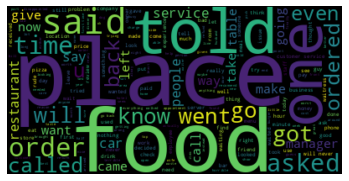

In [13]:
one_df = reviews_df[reviews_df['stars'] == 1]

one_words = " ".join(review for review in one_df['text'])
one_wc = WordCloud(stopwords = stopwords).generate(one_words)
plt.imshow(one_wc, interpolation='bilinear')
plt.axis("off")

plt.show()

#### Heatmap

For our last visualization, we look at a heatmap, which will display relationships among the numerical values of our data.  While this does not add to our NLP model, it can help us understand a little more about the data.  Is the review stars rating correlated with others considering it cool, funny, or useful?

In [14]:
corr_matrix = reviews_df.corr()
print(corr_matrix)

           stars    useful     funny      cool
stars   1.000000 -0.080182 -0.053293  0.071509
useful -0.080182  1.000000  0.575466  0.690004
funny  -0.053293  0.575466  1.000000  0.708302
cool    0.071509  0.690004  0.708302  1.000000


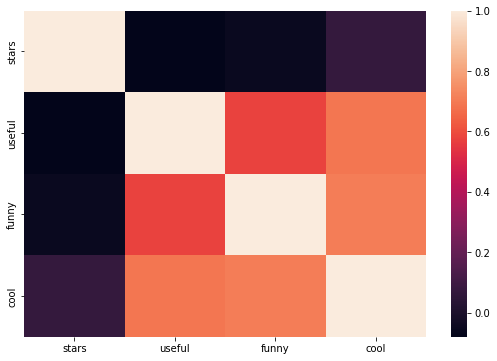

In [15]:
import seaborn as sns
plt.figure(figsize=(9,6))
sns.heatmap(corr_matrix)
plt.show()

## Using Logistic Regression to predict the number of stars by the useful, funny and cool columns

In [16]:
# First we create the feature and label DataFrame necessary for the logistic regression

feature_df = reviews_df.drop(['stars','text', 'business_id', 'review_id', 'user_id','date'], axis=1)
label_df = reviews_df['stars'].copy()

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=123)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print('RMSE: ', rmse)

RMSE:  1.8208727432682852


Logistic Regression Confusion Matrix:


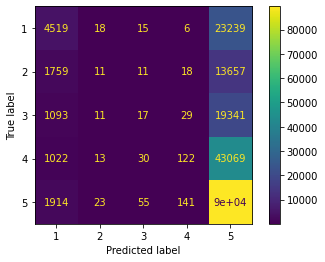

In [19]:
import matplotlib.pyplot as plt

print("Logistic Regression Confusion Matrix:")
lr_confuse = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=lr_confuse, display_labels=lr.classes_)
disp.plot()
plt.show()

### Using Logistic regression, we see that we are accurately predicting the 5 star rating but it is not indicitave because the dataset is skewed towards 5 stars. The other star predictions are not accurate.


## Lasso Feature Selection

#### To further understand the relationships between the variables in our data set we used a lasso feature selection to detect if the useful, funny and cool columns did not have a significant correlation with the star rating.

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

X = x_train
y = y_train

estimator = LassoCV(cv=5, normalize = True)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(estimator, threshold=0.25, prefit=False, norm_order=1, max_features=None)

sfm.fit(X, y)

feature_idx = sfm.get_support()
feature_name = X.columns[feature_idx]
feature_name

/home/mroohwee/.local/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Index([], dtype='object')

#### As a result we are comfortable in dropping the funny, useful and cool columns

## Natural Language Processing

### Data Cleanup

Before fitting our data to the model, we first cleaned the data.  We started by removing any columns we knew we would not use.

In [21]:
cols_to_drop =["review_id", "user_id", "useful", "funny", "cool", "date"]
reviews_df.drop(cols_to_drop, inplace= True, axis=1)
reviews_df.head()

,business_id,stars,text
0,XQfwVwDr-v0ZS3_CbbE5Xw,3,"If you decide to eat here, just be aware it is..."
1,7ATYjTIgM3jUlt4UM3IypQ,5,I've taken a lot of spin classes over the year...
2,YjUWPpI6HXG530lwP-fb2A,3,Family diner. Had the buffet. Eclectic assortm...
3,kxX2SOes4o-D3ZQBkiMRfA,5,"Wow! Yummy, different, delicious. Our favo..."
4,e4Vwtrqf-wpJfwesgvdgxQ,4,Cute interior and owner (?) gave us tour of up...


#### Remove non-English reviews

One of the issues we observed with the data was the presence of non-English reviews.  We had a few options at this point.  We could have attempted to detect each language and then use that detected language for NLP, however upon researching, detecting the correct language seems to be an issue yet to be fully solved in the data science community.  As a result, we chose to attempt to detect the language and if the review contained English, to leave the review, otherwise remove it.


In [22]:
reviews_df['text'] = reviews_df['text'].replace(r'\n', ' ', regex=True)

An alternative method for reviewing the data for Enlgish characters is to look for ASCII characters that are greater than 127 (the maximum ASCII value for the English characters).

We can use this on our cleaned column to see if there are any non-English characters remaining.

In [23]:
def isEnglish(string):
    for character in string:
        if ord(character) > 127:
            return False
    return True
reviews_df['language'] = reviews_df['text'].apply(isEnglish)

reviews_df.sample(20)

,business_id,stars,text,language
42901,jtsckI_01hlbGLpEFwJu0A,5,I usually get my brazilian at a chain called E...,True
80025,ZfbeERrUqkP48cr0rey3Mg,4,The Gazebo apartments are a wonderful place to...,True
808242,kvOorg6F1gnbPmlTtjunsg,5,"Love, love, live BBQ4Life! Fall-off-the-bone p...",True
193017,G4mEyZGeS_4JOuAQWg2dJA,5,"Consistent, quick delivery. I've ordered here...",True
338738,w6z28easvQLND722s4pNvw,5,Oh my goodness!!! We ordered for the first tim...,True
66037,to95MZH1XV_fNLOXNMZQmQ,2,Food was good and restaurant was clean. Two ta...,True
350094,26pdwbxIfWaElarl0aNfyw,5,Now that they've fired that guy (and probably ...,True
198838,BWITd9JUXP3gSi1z3Y-z8g,2,12/17/11 for dinner. OK. we take responsibili...,True
770797,POwyAA0vf4PvWe1L8Oc3Eg,3,"**** EDIT: Jason, the owner of Books & Brew re...",True
949928,KH9ghKDytIlUwlkEioqreg,5,We had our Christmas Party here last night and...,True


First we look at the reviews which were tagged as non-English.  As we can see, these appear to be in English.

We can also look at the ones tagged as English, to further investigate.

These also appear to be English. Since emojis and other characters, such as the tilde n in "jalapeño" would be recognized as non-English characters. By filtering out the non-English charachters we lose ~20,000 out of 1 million rows from our dataset.

In [24]:
reviews_df[reviews_df['language'] == False].count

<bound method DataFrame.count of                    business_id  stars  \
2       YjUWPpI6HXG530lwP-fb2A      3   
29      ltBBYdNzkeKdCNPDAsxwAA      2   
68      PzhPMkaNYiKDTHoTG0r8rw      4   
287     N2i1U4Z6GHEw9V02N2u6JA      5   
382     JcP1z6eZBgTIcxWlyxSw0g      5   
...                        ...    ...   
999380  0NtUzPQr3rykg6km2F6L7w      1   
999444  hfbZ97Te3T4jeWN6GgsGrQ      4   
999828  h07Yfix2ynwn9fJ3proGXQ      1   
999835  j-qtdD55OLfSqfsWuQTDJg      5   
999965  OZcl2HOUXAHuICrh5d2WjQ      5   

                                                     text  language  
2       Family diner. Had the buffet. Eclectic assortm...     False  
29      I at least have to give this restaurant two st...     False  
68      After 3 weeks of working in the area I finally...     False  
287     We used The Hollander Hotel for our wedding ho...     False  
382     After today's lunch, Iris has moved to the top...     False  
...                                                   

## Tokenize and lemmatize data

We created a function to process our data word by word.  
* The function first checks for stopwords and English words as well as non-alpha characters and adds them to a list of tokens.
* Next, each word in the token list is lemmatized and then joined back together for the final text.  
* Lastly, the sentiment of the final text is analyzed and a polarity score is assigned.

In [29]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mroohwee/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [35]:
cachedStopWords = stopwords.words("english")
def process_review(review):
    # get the text in the review
    sentence = review.strip()
    # tokenize the text
    tokens = word_tokenize(sentence.lower())
    tokens = [x for x in tokens if x not in cachedStopWords and x.isalpha()]
    # lematize the tokens
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(x) for x in tokens]
    final_text = ' '.join(tokens)
    # analyze the sentence
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(final_text)
    return score

#### We iterate over the dataset and use the process review function to create predicted stores for each review based on the sentiment.



In [36]:
reviews_df_sample = reviews_df.sample(100000).reset_index()
scores = []

reviews = reviews_df_sample['text'].values.tolist()

# Use ThreadPoolExecutor for parallel processing
with ccf.ThreadPoolExecutor() as executor:
    # Process each review concurrently and store the results in the scores list
    scores = list(executor.map(process_review, reviews))

In [37]:
reviews_df = reviews_df[reviews_df['language'] == True]

#### The polarity score is represented by negative, neutral, and positive score, as well as a compound score which reflects the final sentiment of the text in each review, with available values ranging from -1 to 1 for the compound score.  Our team reviewed several options for how to process the data output below and convert those values into the most accurate representation of the one to five stars used on Yelp, including examining specific reviews to understand why the model rated some as overall positive and others negative.  We saw some glaringly obvious ones, including ones where profanity laden rants were rated relatively high in their compound score.

In [38]:
scores_df = pd.DataFrame(scores)
scores_df.head(10)

,neg,neu,pos,compound
0,0.241,0.759,0.000,-0.5423
1,0.079,0.631,0.290,0.7717
2,0.193,0.745,0.061,-0.9020
3,0.000,0.726,0.274,0.9935
4,0.116,0.697,0.188,0.8107
5,0.000,0.258,0.742,0.9538
6,0.000,0.528,0.472,0.9360
7,0.102,0.658,0.240,0.4939
8,0.000,0.262,0.738,0.9702
9,0.000,0.786,0.214,0.8271


In [39]:
new_df = pd.concat([reviews_df_sample, scores_df], axis=1) 
new_df

,index,business_id,stars,text,language,neg,neu,pos,compound
0,84593,stJax2pMd3PVBbHZthlOdg,4,This location has rebounded from a prior bad e...,True,0.241,0.759,0.000,-0.5423
1,42464,9-QCbaBzR_xFKdaqht4yWA,5,"Carter's Florist, are the most awesome people....",True,0.079,0.631,0.290,0.7717
2,188781,Ge6Ta-4SF1t97-VWoiQLSA,2,"Well, our furniture came into the store within...",True,0.193,0.745,0.061,-0.9020
3,656390,eL673KqwAGpJQ4z-MAaZ7Q,5,Looking for a warm seasonal dine-in meal on a ...,True,0.000,0.726,0.274,0.9935
4,86583,osOONoA8wMF5ZpLWUS7VOw,2,I love that there is a local coffee shop/lunch...,True,0.116,0.697,0.188,0.8107
...,...,...,...,...,...,...,...,...,...
99995,375661,GgUkBi6RHLQ4Joyo0MWpBg,5,CrossFit NapTown is a great place for three re...,True,0.000,0.751,0.249,0.8074
99996,417448,q75UQjNm6AEK4XNnkDLxTQ,5,Chef Ramon does it again! I don't understand ...,True,0.169,0.601,0.230,0.1124
99997,953040,8iwHNfwFISliQNJhrD4SFQ,4,This is a must every time we go to the mall. ...,True,0.000,0.519,0.481,0.8126
99998,991755,TjBvLFDUj2Hz6bkELIJbng,5,Another enjoyable experience at Bar Fly in Saf...,True,0.051,0.635,0.314,0.9814


#### Below is the function we created to convert the compound score to the relative stars rating, normalizing to the compound scores the model applied to the set.

#### In reviewing how to convert from a compound score to a we looked at several other yelp repositories: 
* https://github.com/topics/yelp-data-analysis
* https://github.com/zoehuang7/Yelp-Review-Analysis
* https://dspace.mit.edu/bitstream/handle/1721.1/130685/1251779073-MIT.pdf?sequence=1&isAllowed=y

In [40]:
min_norm = 1
max_norm = 5
min_score = min(scores_df['compound'])
print(min_score)
max_score = max(scores_df['compound'])
print(max_score)

def cmpd_to_stars(compound):
    min_cmpd = np.min(compound)
    max_cmpd = np.max(compound)
    b = np.round(((compound - min_cmpd)/(max_cmpd - min_cmpd)*4)+1)
    return b

-0.9954
0.9998


In [41]:
new_df['stars_pred'] = cmpd_to_stars(new_df['compound'])

## Vizualizing Our Model

Below is our countplot of the stars distribution among the dataset.  We can compare that with the distribution of predicted star ratings in our model.

<AxesSubplot:xlabel='stars', ylabel='count'>

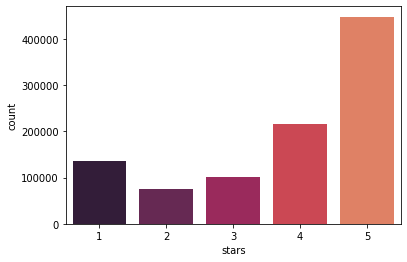

In [42]:
sns.countplot(x = 'stars', data = reviews_df)

<AxesSubplot:xlabel='stars_pred', ylabel='count'>

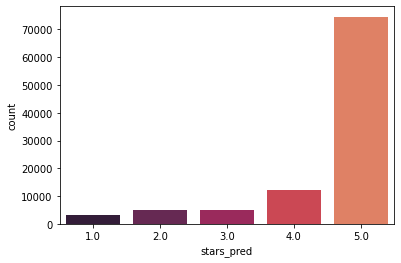

In [43]:
sns.countplot(x = 'stars_pred', data = new_df)

#### Our model predicted far more five star reviews than actually comprise our dataset, and underperformed in predicting every other star rating.  This may go back to the distribution of stars within our dataset and not having enough data for other stars to accurately predict.

In [44]:
f1 = f1_score(new_df['stars'], new_df['stars_pred'], average='micro')
print("F1 Score:", f1)

F1 Score: 0.47516


#### In an attempt to improve upon this we are trying to find a better transformation the compund score given by the vader analyzer into a star rating.

In [45]:
new_df['stars'] = new_df['stars'].astype('category')

In [46]:
# First we create the feature and label DataFrame necessary for the logistic regression
x = new_df.drop(['stars','text', 'business_id', 'index', 'language','neg','pos','neu'], axis=1)
y = new_df['stars'].copy()

In [47]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [48]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=123)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
f1 = f1_score(y_test, lr_pred, average='micro')
print('F1 score: ', f1)

F1 score:  0.53075


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(x_train, y_train)
tree_pred = tree_model.predict(x_test)

f1 = f1_score(y_test, tree_pred, average='micro')
print('F1 score: ', f1)

F1 score:  0.51825


In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)

f1 = f1_score(y_test, rf_pred, average='micro')
print('F1 score: ', f1)

F1 score:  0.53215


## Conclusion

The exploration of the Yelp academic dataset provided a valuable opportunity for our team to collaborate and brainstorm.  We reviewed the dataset initially and grappled with the sheer size of the data, learned abour Tar files, and worked some in PySpark. We dove headfirst into how clean data should be for a natural language processing model and weighed the pros and cons of cleaning data that we knew had non-English characters (whether to drop those reviews in an effort to retain more valuable data instead) or to only allow those words to be removed within our tokenizing portion of our model.  We learned a lot about sentiment analysis and polarity scores and looked at another model and if they could be better predictors.

The conversion from a compound score to a predicted star rating proved to be rather tricky, we tried logistic regression, random forest classifictation, decision tree classification and the highest F1 score we were able to achieve was with the logistic regression model at 0.534.
To improve upon the F1 score some things we could try in the future are:
* Further Data Cleaning
* Different NLP Libraries and techniques
* More historical user data, that would allow us to see if the textual data aligns with scores given
* Find better ways to process the entire data set so that star ratings arent as skewed towards one end